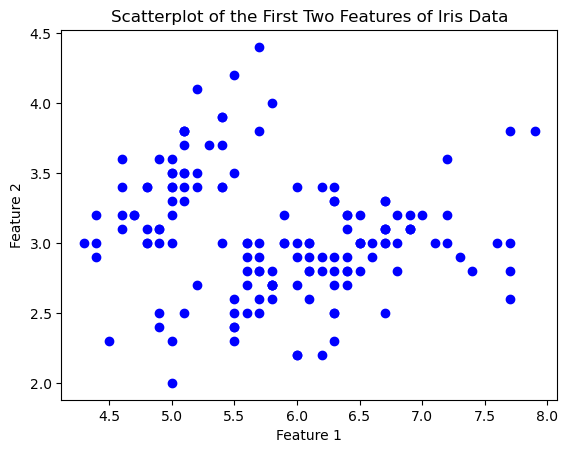

Iteration 1, Log-Likelihood: [-270.16248638]
Iteration 2, Log-Likelihood: [-269.49420502]
Iteration 3, Log-Likelihood: [-268.573093]
Iteration 4, Log-Likelihood: [-267.24260222]
Iteration 5, Log-Likelihood: [-265.48692994]
Iteration 6, Log-Likelihood: [-263.40690766]
Iteration 7, Log-Likelihood: [-260.98856674]
Iteration 8, Log-Likelihood: [-257.97619041]
Iteration 9, Log-Likelihood: [-254.08052541]
Iteration 10, Log-Likelihood: [-249.74699532]
Iteration 11, Log-Likelihood: [-245.920929]
Iteration 12, Log-Likelihood: [-242.05971395]
Iteration 13, Log-Likelihood: [-237.19872301]
Iteration 14, Log-Likelihood: [-231.43296934]
Iteration 15, Log-Likelihood: [-226.76375399]
Iteration 16, Log-Likelihood: [-224.59755365]
Iteration 17, Log-Likelihood: [-223.7841884]
Iteration 18, Log-Likelihood: [-223.2641419]
Iteration 19, Log-Likelihood: [-222.81571452]
Iteration 20, Log-Likelihood: [-222.40269703]
Iteration 21, Log-Likelihood: [-222.03990754]
Iteration 22, Log-Likelihood: [-221.75275933]
Ite

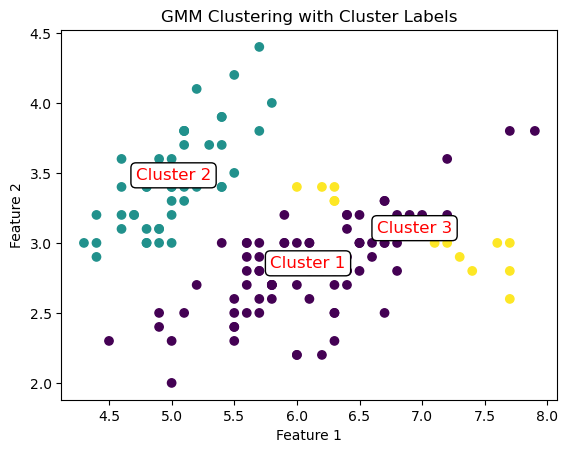

Final Means:
[[6.08888907 2.82217089]
 [5.01532738 3.45066501]
 [6.93961721 3.07323443]]

Final Covariances:
[[[ 0.37498463  0.13735786]
  [ 0.13735786  0.11588614]]

 [[ 0.11916052  0.0878893 ]
  [ 0.0878893   0.11850464]]

 [[ 0.26280812 -0.0892068 ]
  [-0.0892068   0.04246029]]]

Final Weights:
Cluster 1 Weight: 0.552554020455487
Cluster 2 Weight: 0.3254242735321867
Cluster 3 Weight: 0.12202170601232622
[0.55255402 0.32542427 0.12202171]

Total Iterations Needed: 50


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Load the Iris dataset and extract the first two columns
df = pd.read_csv('iris.csv')  # Replace with the correct path to your dataset
X = df.iloc[:, :2].values  # Extract first two columns as NumPy array

# Plot the raw data
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o')
plt.title("Scatterplot of the First Two Features of Iris Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Step 2: Initialize parameters for the GMM
def initialize_parameters(X, K):
    n, d = X.shape
    means = X[np.random.choice(n, K, replace=False)]  # Random initialization of means
    covariances = np.array([np.eye(d) for _ in range(K)])  # Identity matrices for covariances
    weights = np.ones(K) / K  # Equal weights initially
    return means, covariances, weights

# Step 3: Define Gaussian PDF
def gaussian_pdf(X, mean, covariance):
    d = X.shape[1]
    det_cov = np.linalg.det(covariance)
    inv_cov = np.linalg.inv(covariance)
    norm_factor = (2 * np.pi) ** (-d / 2) * det_cov ** (-0.5)
    diff = X - mean
    return norm_factor * np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))

# Step 4: Expectation Step
def expectation_step(X, means, covariances, weights, K):
    n = X.shape[0]
    gamma = np.zeros((n, K))
    for k in range(K):
        gamma[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
    gamma /= np.sum(gamma, axis=1, keepdims=True)
    return gamma

# Step 5: Maximization Step
def maximization_step(X, gamma, K):
    n, d = X.shape
    Nk = np.sum(gamma, axis=0)
    means = np.array([np.sum(gamma[:, k, None] * X, axis=0) / Nk[k] for k in range(K)])
    covariances = []
    for k in range(K):
        diff = X - means[k]
        cov = np.sum(gamma[:, k, None, None] * np.einsum('ij,ik->ijk', diff, diff), axis=0) / Nk[k]
        covariances.append(cov)
    covariances = np.array(covariances)
    weights = Nk / n
    return means, covariances, weights

# Step 6: Log-Likelihood
def compute_log_likelihood(X, means, covariances, weights, K):
    n = X.shape[0]
    log_likelihood = 0
    for i in range(n):
        likelihood = 0
        for k in range(K):
            likelihood += weights[k] * gaussian_pdf(X[i:i+1], means[k], covariances[k])
        log_likelihood += np.log(likelihood)
    return log_likelihood

# Step 7: Perform EM Algorithm
def gmm_em(X, K, max_iters=100, tol=1e-4):
    means, covariances, weights = initialize_parameters(X, K)
    log_likelihoods = []
    
    for iteration in range(max_iters):
        # Expectation Step
        gamma = expectation_step(X, means, covariances, weights, K)
        
        # Maximization Step
        means, covariances, weights = maximization_step(X, gamma, K)
        
        # Compute Log-Likelihood
        log_likelihood = compute_log_likelihood(X, means, covariances, weights, K)
        log_likelihoods.append(log_likelihood)
        
        # Print iteration details
        print(f"Iteration {iteration + 1}, Log-Likelihood: {log_likelihood}")
        
        # Check for convergence
        if iteration > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

    return means, covariances, weights, gamma, log_likelihoods, iteration + 1

# Step 8: Run the EM algorithm
K = 3  # Number of clusters
means, covariances, weights, gamma, log_likelihoods, iterations_needed = gmm_em(X, K)

# Step 9: Assign labels and plot the clusters
labels = np.argmax(gamma, axis=1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')

# Add cluster labels to the scatter plot
for i, mean in enumerate(means):
    plt.text(mean[0], mean[1], f"Cluster {i+1}", fontsize=12, color='red', 
             ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.title("GMM Clustering with Cluster Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Print final parameter estimates
print("Final Means:")
print(means)
print("\nFinal Covariances:")
print(covariances)
print("\nFinal Weights:")
for i, weight in enumerate(weights):
    print(f"Cluster {i+1} Weight: {weight}")
print(weights)
print(f"\nTotal Iterations Needed: {iterations_needed}")
